# **Prediction of cell viability from Cell Painting profiles**
This notebook is used to build a Random Forest model for the prediction of cell viability from Cell Painting profiles extracted with CellProfiler or Harmony.
A data oversampling algorithm can be applied to the training set to balance the number of samples in each class.

**Data input and basic formatting:**

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toxifate import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import smogn
import numpy as np
import plotly.express as px

SMOGN = 'True'

csv_per_well = "C:\\Users\\Roman\\OneDrive - National University of Ireland, Galway\\CellPainting project data\\CellProfiler\\PerWell\\tubesPolyByWellProfiler.csv"
viability_file = "C:\\Users\\Roman\\OneDrive - National University of Ireland, Galway\\plate reader\\CTG-fullWellNormresults.csv"

fileFormat = 'cp' # 'harmony' or 'cp'
viability_table_per_well = pd.read_csv(viability_file)

table_per_well = pd.read_csv(csv_per_well)
if fileFormat == 'harmony':
    table_per_well = table_per_well.drop(columns=['Unnamed: 0'])
elif fileFormat == 'cp':
    table_per_well = table_per_well.drop(columns=['Unnamed: 0'])
viability_table_per_well

,Unnamed: 0,Plate,Well,1s luciferase (CPS),Row,Column,Concentration,Compound
0,0,aB1,A01,0.420143,1,1,0,none
1,1,aB1,A02,0.701689,1,2,0,none
2,2,aB1,A03,115.530466,1,3,0,none
3,3,aB1,A04,117.776712,1,4,0,none
4,4,aB1,A05,113.804258,1,5,0,none
...,...,...,...,...,...,...,...,...
9731,259,gT5,N19,107.674235,14,19,10000,ZIDO
9732,260,gT5,N20,103.564534,14,20,10000,ZIDO
9733,261,gT5,N21,102.288023,14,21,30000,ZIDO
9734,262,gT5,N22,104.278182,14,22,30000,ZIDO


# Data formatting and merging with viability data
File format recognition (CellProfiler or Harmony). 
Grouping viability table and profile table by drug and concentration using the median value

In [16]:
if fileFormat == 'cp':
    table_per_well.rename(columns={'Metadata_Compound':'Compound', 'Metadata_Concentration (Image)':'Concentration','Metadata_Well':'Well'}, inplace=True)
    table_per_well.drop(columns=['PlateID','Well'], inplace=True)

# aggregate viability_table_per_well by Compound and Concentration, median, discard Row, Column, Unnamed: 0,Plate,Well
viability_table_per_treatment = viability_table_per_well.groupby(['Compound', 'Concentration']).median(numeric_only=True).reset_index()
viability_table_per_treatment = viability_table_per_treatment.drop(columns=['Row', 'Column', 'Unnamed: 0'])


# aggregate table_per_well by Compound and Concentration, median, discard Row and Column
table_per_treatment = table_per_well.groupby(['Compound', 'Concentration']).median(numeric_only=True).reset_index()
table_per_treatment.drop(columns=['Row', 'Column'], inplace=True, errors='ignore')
table_per_treatment.insert(loc=3, column='Viability', value=viability_table_per_treatment['1s luciferase (CPS)'])
table_per_treatment.head()
#remove columns with too many missing values
table_per_treatment = table_per_treatment.dropna(axis=1)
table_per_treatment


#plot the distribution of Viability values with a displot (kde), by Compound

#sns.displot(data=table_per_treatment.loc[table_per_treatment['Compound'] != 'DMSO'], x="Viability", hue="Compound", kind="kde", fill=True, col='Compound', col_wrap=6,facet_kws=dict(sharey=False),cut=0, legend=False)

,Compound,Concentration,Count,Viability,AreaShape_Area (Nuclei),AreaShape_BoundingBoxMaximum_X (Nuclei),AreaShape_BoundingBoxMaximum_Y (Nuclei),AreaShape_BoundingBoxMinimum_X (Nuclei),AreaShape_BoundingBoxMinimum_Y (Nuclei),AreaShape_Center_X (Nuclei),...,Texture_Variance_ER_3_02_256 (Tubes),Texture_Variance_ER_3_03_256 (Tubes),Texture_Variance_MITO_3_00_256 (Tubes),Texture_Variance_MITO_3_01_256 (Tubes),Texture_Variance_MITO_3_02_256 (Tubes),Texture_Variance_MITO_3_03_256 (Tubes),Texture_Variance_RNA_3_00_256 (Tubes),Texture_Variance_RNA_3_01_256 (Tubes),Texture_Variance_RNA_3_02_256 (Tubes),Texture_Variance_RNA_3_03_256 (Tubes)
0,ATOR,10,174.1,98.262090,-0.416554,0.439721,-0.067363,0.398059,-0.070208,0.391460,...,-0.681490,-0.634247,0.364182,0.371763,0.412353,0.457564,-0.499347,-0.356443,-0.340559,-0.730945
1,ATOR,30,180.9,94.406498,-0.364728,0.004944,0.274704,-0.001199,0.268512,-0.001458,...,0.861161,0.841876,1.087101,1.086995,1.086221,1.086681,0.786716,0.523160,0.566125,0.992816
2,ATOR,100,167.0,95.387465,0.023552,-0.336701,0.365684,-0.329487,0.367612,-0.348614,...,0.861161,0.841876,0.364182,0.371763,0.412353,0.457564,0.053585,0.523160,0.227609,-0.040317
3,ATOR,300,167.1,91.679638,-0.409997,-0.151827,0.226834,-0.131013,0.230880,-0.148479,...,-0.002469,0.120988,0.364182,0.371763,0.412353,0.457564,-0.326950,0.167852,-0.013015,-0.732488
4,ATOR,1000,191.7,93.215158,-0.225798,-0.087606,0.203530,-0.063537,0.219048,-0.078404,...,0.084868,0.175944,0.148539,0.150112,0.102653,0.093474,0.229883,0.276910,0.276555,-0.028310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ZIDO,300,175.2,103.726408,-0.532602,-0.231918,-0.030341,-0.165028,0.018898,-0.206765,...,-0.010959,0.045657,-0.173985,-0.243657,-0.222182,-0.193719,0.250411,0.279971,0.260964,0.291821
237,ZIDO,1000,200.5,101.589529,0.472813,-0.105939,-0.237638,-0.126970,-0.191171,-0.113706,...,0.594559,0.600628,0.167920,0.144529,0.146259,0.240428,0.282791,0.415259,0.379502,0.417197
238,ZIDO,3000,188.9,98.338109,-0.109513,0.016375,0.435465,-0.007904,0.466768,-0.006231,...,-0.010959,0.045657,-0.173985,-0.243657,-0.222182,-0.193719,0.408993,0.311797,0.394398,0.417197
239,ZIDO,10000,189.9,99.459198,-0.095676,-0.320778,0.111551,-0.288444,0.091680,-0.297980,...,0.732717,0.674120,0.509825,0.532715,0.514699,0.674574,0.441372,0.582372,0.512936,0.515744


## Oversampling of high toxicity profiles, downsampling of low toxicity
SMOGN algorithm, can be turned off in the parameters. A plot of the distribution of the viability values is shown before and after the oversampling.

synth_matrix: 100%|##########| 24/24 [00:38<00:00,  1.62s/it]


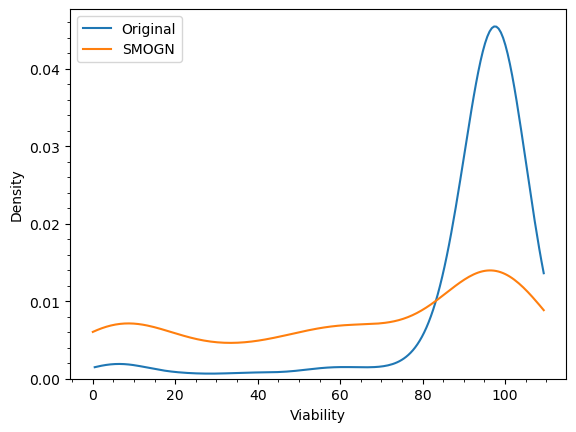

In [19]:
#remove correlated features from table_per_treatment
#table_per_treatment = Drop_correlated_columns(table_per_treatment, 0.9)

#oversample the data to balance the Viability values between 0 and 100
augmentedData = smogn.smoter(data = table_per_treatment, 
                             y = "Viability", 
                             rel_xtrm_type = "low", 
                             samp_method='balance',
                             rel_coef = 5,
                             rel_thres = 0.8)
sns.kdeplot(table_per_treatment['Viability'], label = "Original", cut=0)
sns.kdeplot(augmentedData['Viability'], label = "SMOGN",cut=0)
#add minor ticks to x axis 
plt.minorticks_on()
plt.legend()

In [20]:
if SMOGN == 'False':
    augmentedData = table_per_treatment

#train a random forest regressor to predict viability from the other features
#split the data into train and test sets
augmentedData.reset_index(drop=True, inplace=True)
augmentedData = augmentedData.sample(frac=1).reset_index(drop=True) # shuffle rows to avoid chunks of same drugs with stratified cv
X = augmentedData.drop(columns=['Compound', 'Concentration', 'Viability','Count'])
y = augmentedData['Viability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train the model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

#predict the viability values for the test set
y_pred = rf.predict(X_test)

#calculate the mean squared error and the R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# merge y_test and y_pred into a dataframe, and add the Compound and Concentration columns using merge

y_test = pd.DataFrame(y_test)
y_test['Predicted Viability'] = y_pred
y_test = y_test.merge(augmentedData[['Compound', 'Concentration']], left_index=True, right_index=True)



In [21]:

#plot the actual and predicted viability values for each compound, fixed axis limits to 0-100

fig = px.scatter(y_test, x="Viability", y="Predicted Viability", color="Compound", hover_data=['Concentration'], trendline="ols", trendline_scope='overall',height=1000, width=1200, range_x=[0,100], range_y=[0,100], title = 'Test set' )
fig.update_traces(marker={'size': 10})
fig.update_layout(
    font=dict(
        size=18,
        color="black"
    )
)
fig.show()

print('Mean squared error: ', mse)
print('R2 score: ', r2)


Mean squared error:  43.39007981516708
R2 score:  0.9688438810113577


In [22]:
y_train = pd.DataFrame(y_train)
y_train['Predicted Viability'] = rf.predict(X_train)
y_train = y_train.merge(augmentedData[['Compound', 'Concentration']], left_index=True, right_index=True)

fig2 = px.scatter(y_train, x="Viability", y="Predicted Viability", color="Compound", hover_data=['Concentration'], trendline="ols", trendline_scope='overall',height=1000, width=1200, range_x=[0,100], range_y=[0,100], title = 'Train set') 

fig2.update_traces(marker={'size': 10})
fig2.update_layout(
    font=dict(
        size=18,
        color="black"
    )
)
fig2.show()
r2_score(y_train['Viability'], y_train['Predicted Viability'])

0.994364335703305

In [23]:
#calculate the feature importance
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(15)

,importance
RadialDistribution_RadialCV_RNA_3of4 (Cells),0.424756
RadialDistribution_RadialCV_ER_3of4 (Cells),0.243198
Mean_Nuclei_Granularity_8_MITO (Tubes),0.086724
Intensity_MinIntensity_AGP (Nuclei),0.038412
Intensity_MinIntensityEdge_RNA (Cells),0.023060
RadialDistribution_RadialCV_MITO_1of4 (Nuclei),0.015611
Intensity_MinIntensity_RNA (Cells),0.011847
Texture_InfoMeas1_MITO_3_01_256 (Cells),0.009549
Intensity_MaxIntensityEdge_ER (Cells),0.008340
Intensity_IntegratedIntensity_ER (Cells),0.007854


In [24]:
#now perform cross-validation to get a better estimate of the model performance, and plot the predicted vs actual values
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print('R2 scores: ', scores)
print('Mean R2 score: ', scores.mean())

R2 scores:  [0.99135015 0.98871731 0.95142249 0.97063144 0.9630893 ]
Mean R2 score:  0.9730421401843742


In [25]:

#plot the predicted vs actual values, and display the regression line and R2 score
from sklearn.model_selection import cross_val_predict
import plotly.express as px
augmentedData = augmentedData.reset_index(drop=True)
#randomize row order
X = augmentedData.drop(columns=['Compound', 'Concentration', 'Viability','Count'])
y = augmentedData['Viability']

y_pred = cross_val_predict(rf, X, y, cv=5)
# add back the compound and concentration columns
y_pred = pd.DataFrame(y_pred, columns=['Viability'])
y_pred = pd.concat([augmentedData[['Compound', 'Concentration']], y_pred], axis=1)
augmentedData['Prediction'] = y_pred['Viability']

fig = px.scatter(augmentedData, 
                 x="Viability", y="Prediction", 
                 trendline="ols", title='Treat level (Cross-Validation)', 
                 hover_data=['Compound', 'Concentration'], 
                 height=1000, width=1000, 
                 trendline_scope = 'overall', 
                 color='Compound', 
                 range_x=[0,100], range_y=[0,100])

fig.update_layout(title='Well level (Cross-Validation)',
                     xaxis_title='Actual Viability',
                     yaxis_title='Predicted Viability')


fig.show()
r2_cv = r2_score(augmentedData['Viability'], augmentedData['Prediction'])
print('Cross-validated R2 score: ', r2_cv)

Cross-validated R2 score:  0.9726264744293479


In [26]:
# run the same analysis without aggregation
table_per_well2 = table_per_well.drop(columns=['Row', 'Column', 'PlateName'], errors='ignore')

#join viability data to the table_per_well, on Compound and Concentration columns
per_well_withviability = table_per_well2.merge(viability_table_per_treatment, on=['Compound', 'Concentration'])
#drop Unnamed: 0, Plate, Well, all columns ending with _y, and rename 1s luciferase (CPS) to Viability
per_well_withviability.rename(columns={'1s luciferase (CPS)': 'Viability'}, inplace=True)
per_well_withviability

,Compound,Concentration,Count,nan (Unnamed: 0),AreaShape_Area (Nuclei),AreaShape_BoundingBoxArea (Nuclei),AreaShape_BoundingBoxMaximum_X (Nuclei),AreaShape_BoundingBoxMaximum_Y (Nuclei),AreaShape_BoundingBoxMinimum_X (Nuclei),AreaShape_BoundingBoxMinimum_Y (Nuclei),...,Texture_Variance_ER_3_03_256 (Tubes),Texture_Variance_MITO_3_00_256 (Tubes),Texture_Variance_MITO_3_01_256 (Tubes),Texture_Variance_MITO_3_02_256 (Tubes),Texture_Variance_MITO_3_03_256 (Tubes),Texture_Variance_RNA_3_00_256 (Tubes),Texture_Variance_RNA_3_01_256 (Tubes),Texture_Variance_RNA_3_02_256 (Tubes),Texture_Variance_RNA_3_03_256 (Tubes),Viability
0,NCAP,30,162.0,-1.240117,-0.788746,-0.700432,0.151219,-0.053900,0.196646,0.115204,...,0.962424,1.087101,1.086995,1.086221,1.086681,0.786716,0.632219,0.566125,1.014626,96.597931
1,NCAP,30,146.2,-1.265406,-0.171886,-0.093453,-1.655051,4.934553,-1.674526,4.938070,...,-2.296142,-0.935561,-0.950006,-1.001710,-1.009461,-2.807132,-3.109808,-3.186887,-1.865935,96.597931
2,NCAP,30,182.4,-0.765142,-0.114055,-0.093453,-1.119860,-0.967933,-1.158914,-0.937343,...,-0.544944,-0.916999,-0.906324,-0.882400,-0.903143,0.786716,-0.078398,0.566125,1.014626,96.597931
3,NCAP,30,153.6,-0.788327,-0.673085,-0.700432,-1.730312,-0.720059,-1.766005,-0.654569,...,13.225253,10.547510,8.473764,10.837200,11.856309,1.478748,0.632219,1.598488,0.992816,96.597931
4,NCAP,30,207.0,NaN,0.420418,NaN,-2.221339,-0.224084,-2.263988,-0.406247,...,0.896832,2.617066,2.651403,2.591082,2.727541,3.974505,4.028478,3.729430,3.417691,96.597931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,ZIDO,10,236.0,NaN,-1.433275,NaN,-1.090357,-1.591211,-1.139592,-1.611928,...,0.700861,0.509825,0.532715,0.514699,0.674574,0.376613,0.582372,0.275860,0.264991,101.228239
3265,ZIDO,10,218.8,NaN,1.191441,NaN,1.641889,0.168723,1.647696,0.150597,...,0.644802,0.714762,0.817636,0.799403,0.834180,0.124209,0.248145,0.246069,0.318651,101.228239
3266,ZIDO,10,163.2,NaN,0.174368,NaN,0.132959,0.512072,0.170025,0.505971,...,-2.207050,-2.294375,-2.292415,-2.281475,-2.160833,-2.054066,-2.289014,-2.277279,-2.154198,101.228239
3267,ZIDO,10,192.8,NaN,1.827112,NaN,-0.380324,-0.836801,-0.386420,-0.824613,...,0.556454,-0.181595,-0.272840,-0.267182,-0.280413,0.124209,0.248145,0.246069,0.318651,101.228239


In [27]:
augmentedData

,Compound,Concentration,Count,Viability,AreaShape_Area (Nuclei),AreaShape_BoundingBoxMaximum_X (Nuclei),AreaShape_BoundingBoxMaximum_Y (Nuclei),AreaShape_BoundingBoxMinimum_X (Nuclei),AreaShape_BoundingBoxMinimum_Y (Nuclei),AreaShape_Center_X (Nuclei),...,Texture_Variance_ER_3_03_256 (Tubes),Texture_Variance_MITO_3_00_256 (Tubes),Texture_Variance_MITO_3_01_256 (Tubes),Texture_Variance_MITO_3_02_256 (Tubes),Texture_Variance_MITO_3_03_256 (Tubes),Texture_Variance_RNA_3_00_256 (Tubes),Texture_Variance_RNA_3_01_256 (Tubes),Texture_Variance_RNA_3_02_256 (Tubes),Texture_Variance_RNA_3_03_256 (Tubes),Prediction
0,SUNI,9529.0,9.500548,7.429372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.653378,1.200504,1.177146,1.170058,1.213151,2.961521,3.052338,2.885011,2.992270,7.797697
1,CERI,30000.0,10.600000,8.638624,-7.298349,-1.511446,-0.350562,-1.441669,-0.281522,-1.502667,...,0.962424,1.087101,1.086995,1.086221,1.086681,0.786716,0.632219,0.566125,0.992816,9.212047
2,SUNI,3184.0,179.063789,22.146737,0.000000,0.544118,0.275996,0.689564,0.452696,0.590459,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.101165,0.241400,0.227744,0.230785,22.987183
3,SUNI,30345.0,66.543399,0.315006,0.000000,0.000000,0.251645,0.000000,0.359883,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.404042
4,CERI,100.0,196.700000,71.996375,-0.737397,-0.362544,0.267613,-0.346066,0.390991,-0.354930,...,0.786920,1.242561,1.242063,1.202066,1.294321,0.610418,0.414102,0.517180,0.821563,75.155679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,TEBU,3000.0,195.700000,99.638826,0.226074,0.414638,-0.492532,0.437896,-0.412276,0.438234,...,0.600628,-0.173985,-0.243657,-0.222182,-0.193719,0.250411,0.415259,0.260964,0.318651,96.984451
213,ETOP,1000.0,157.600000,85.228459,-0.852005,0.200334,-0.274067,0.287841,-0.296794,0.269883,...,-0.085843,-0.005054,-0.010226,-0.030792,-0.015457,0.862282,0.871877,0.767183,0.862739,96.317735
214,DAPT,100.0,156.100000,100.222218,-0.179814,-0.527810,-0.032994,-0.496305,-0.048113,-0.512032,...,0.786920,1.087101,1.086995,1.086221,1.086681,0.434120,0.414102,0.468234,0.650311,96.518491
215,SUNI,415.0,249.409477,66.312121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.051523,0.000000,0.000000,0.000000,0.000000,65.790208


In [28]:
augmentedData2 = smogn.smoter(data = per_well_withviability, y = "Viability", rel_xtrm_type = "low")
sns.kdeplot(per_well_withviability['Viability'], label = "Original", cut=0)
sns.kdeplot(augmentedData2['Viability'], label = "SMOGN",cut=0)
plt.legend()

dist_matrix:  89%|########9 | 544/611 [1:00:47<07:29,  6.70s/it]


KeyboardInterrupt: 

In [ ]:
#train a random forest regressor to predict viability from the other features
#split the data into train and test sets
curatedData = drop_correlated_columns(per_well_withviability.query('Viability < 97'), 0.9, numeric=True)
X2 = curatedData.drop(columns=['Compound', 'Concentration', 'Viability','Count']).dropna(axis=1)
y2 = curatedData['Viability']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=111)

#train the model
rf2 = RandomForestRegressor(n_estimators=100, random_state=72)
rf2.fit(X_train2, y_train2)

#predict the viability values for the test set
y_pred2 = rf2.predict(X_test2)

#calculate the mean squared error and the R2 score
mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)
print('Mean squared error: ', mse)
print('R2 score: ', r22)


Mean squared error:  13.086567522067755
R2 score:  0.8928685729193934


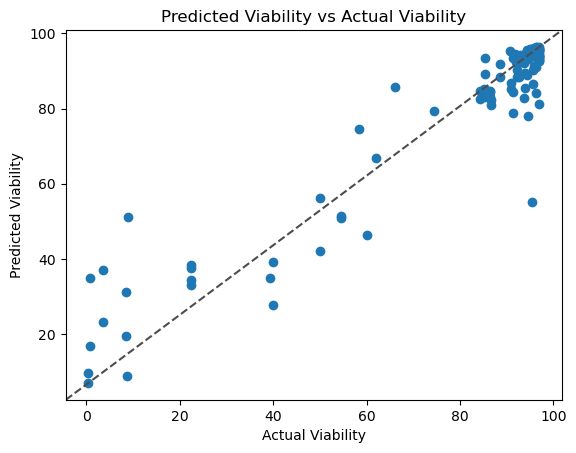

In [ ]:

#add the regression line to the plot, make the plot square
plt.scatter(y_test2, y_pred2 )
plt.xlabel('Actual Viability')
plt.ylabel('Predicted Viability')
plt.title('Predicted Viability vs Actual Viability')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c=".3")
plt.show()

In [ ]:
feature_importances2 = pd.DataFrame(rf2.feature_importances_, index = X_train2.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances2.head(10)

,importance
Cytoplasm 488 Profile 4/5 SER-Edge,0.350247
Nucleus 33342 Profile 5/5,0.178366
Cytoplasm Mito Profile 4/5 SER-Bright,0.123103
Cytoplasm 33342 Profile 3/5 SER-Hole,0.016715
Cytoplasm 33342 Profile 3/5 SER-Edge,0.012692
Cytoplasm 488 Profile 3/5 SER-Dark,0.011226
Cell 33342 Radial Mean,0.011040
Cell 488 Radial Mean Ratio SER-Dark,0.009542
Intensity Cytoplasm Alexa 568 Mean,0.008704
Nucleus 33342 Radial Mean Ratio SER-Bright,0.008264


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv_scores = cross_val_score(rf2, X2, y2, cv=ShuffleSplit(n_splits=5, test_size=0.1, random_state=0))

print("Cross-validation scores: ", cv_scores)
print("Mean score: ", np.mean(cv_scores))
print("Standard deviation: ", np.std(cv_scores))


Cross-validation scores:  [0.88944951 0.83283827 0.87190141 0.89354614 0.86880426]
Mean score:  0.8713079173678405
Standard deviation:  0.021495068675252357
